# Trabajo Práctico 2 : Críticas cinematográficas

Materia: 75.06/95.58 - Organización de Datos

Grupo: 27

Integrantes:\
Jarmolinski, Arian\
Porro, Joaquín\
Bordón Villavicencio, Fernando Nahuel

#### Instalacion, instalacion y descarga de librerias

In [181]:
# !pip install spacy
# !python -m spacy download es_core_news_sm
# !pip install xgboost
# !pip install tensorflow
# !pip install keras
# !pip install langdetect
# !pip install wordcloud

In [182]:
from joblib import dump, load
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import pandas as pd
import numpy as np

import re
import nltk
from nltk.corpus import stopwords
from nltk import SnowballStemmer

import sklearn as sk
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV,train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,f1_score, make_scorer, confusion_matrix,recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import StackingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from xgboost import XGBClassifier
import joblib
from joblib import parallel_backend

In [3]:
# nltk.download('wordnet')
# nltk.download('omw-1.4')

## Carga de datos

### desde Drive

In [4]:
# from google.colab import drive

# drive.mount('/content/drive')
# df_test = pd.read_csv('drive/MyDrive/data/tp2_test.csv')
# df_train = pd.read_csv('drive/MyDrive/data/tp2_train.csv')

### Local

In [184]:
df_train = pd.read_csv('tp2_train.csv')

In [185]:
df_test = pd.read_csv('tp2_test.csv')

## Preprocesamiento

Limpio los review en idioma que no sea español

In [186]:
from langdetect import detect
df_lang = df_train['review_es'].apply(detect)

In [8]:
df_train.shape

(50000, 3)

In [187]:
df_train = df_train[df_lang == 'es']

In [10]:
df_train.shape

(48182, 3)

Filtro las review por stopwords y lematizo las palabras

In [11]:
stopwords_es = set(stopwords.words('spanish'))
stemmer = SnowballStemmer('spanish') 

In [194]:
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar signos de puntuación
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\b\w+\b', lambda match: stemmer.stem(match.group()), text)  # Stemming
    text = ' '.join([word for word in text.split() if word not in stopwords_es])  # Eliminar stopwords
    return text

df_train['review_es'] = df_train['review_es'].apply(preprocess_text)

In [189]:
df_test['review_es'] = df_test['review_es'].apply(preprocess_text)

#### WordCloud

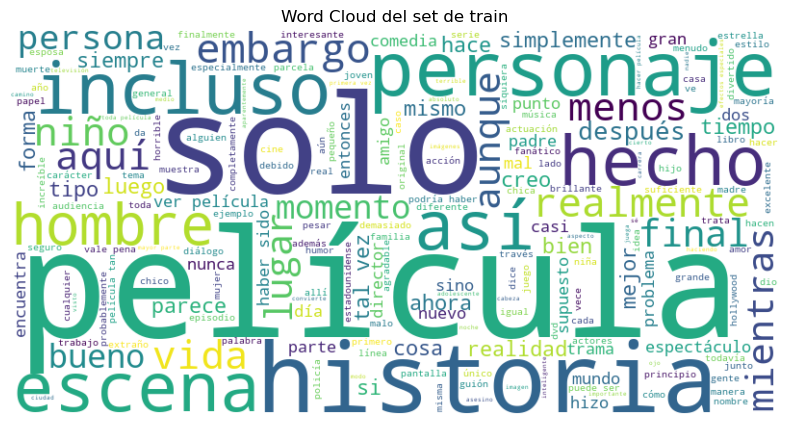

In [193]:
text_data = ' '.join(df_train['review_es'])

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Mostrar el wordcloud utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.title('Word Cloud del set de train')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

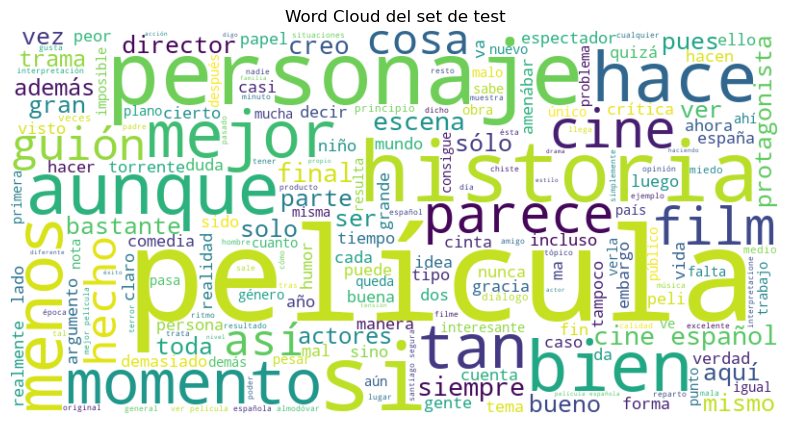

In [192]:
text_data = ' '.join(df_test['review_es'])

# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Mostrar el wordcloud utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.title('Word Cloud del set de test')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### separo en train y test

In [14]:
x_train,x_test,y_train,y_test = train_test_split(df_train['review_es'],
                                                 df_train['sentimiento'],
                                                 test_size = 0.3,
                                                 random_state = 25,
)

### Vectorizo

Anteriormente use Bag of Words, que dio peor resultado que TFIDF

In [15]:
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer(max_features = 25000) 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 10000)

In [17]:
x_train_bow = vectorizer.fit_transform(x_train)

In [18]:
x_train_bow = x_train_bow.toarray()
print(x_train_bow.shape)

(33727, 10000)


In [19]:
test_bow = vectorizer.transform(df_test['review_es']).toarray()

In [20]:
x_test_bow = vectorizer.transform(x_test)
x_test_bow = x_test_bow.toarray()

### Reduccion de la dimensionalidad

Anteriormente se utilizo PCA

In [21]:
# Aplica PCA para reducir la dimensionalidad
pca = PCA(n_components=4000)  # Número de componentes principales a seleccionar
x_train_pca = pca.fit_transform(x_train_bow)

Muestra la explicabilidad total de las n componentes elegidas

In [22]:
variance_ratios = pca.explained_variance_ratio_
variance_ratios.sum()

0.8484334951718238

In [23]:
x_test_pca = pca.transform(x_test_bow)
test_pca = pca.transform(test_bow)

### Encoder del target

para pasar de categorica a binario

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Entrenamiento

## Bayes Naive

In [25]:
parameters = {'alpha': np.linspace(0.1,1.0,10)}

naive_bayes = MultinomialNB()

cv_bayes = GridSearchCV(naive_bayes, parameters, cv=5, scoring='f1',verbose=10)
cv_bayes.fit(x_train_bow, y_train_encoded)

print("Mejores hiperparámetros:", cv_bayes.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START alpha=0.1..................................................
[CV 1/5; 1/10] END ...................alpha=0.1;, score=0.835 total time=   0.8s
[CV 2/5; 1/10] START alpha=0.1..................................................
[CV 2/5; 1/10] END ...................alpha=0.1;, score=0.826 total time=   0.8s
[CV 3/5; 1/10] START alpha=0.1..................................................
[CV 3/5; 1/10] END ...................alpha=0.1;, score=0.834 total time=   0.8s
[CV 4/5; 1/10] START alpha=0.1..................................................
[CV 4/5; 1/10] END ...................alpha=0.1;, score=0.826 total time=   0.8s
[CV 5/5; 1/10] START alpha=0.1..................................................
[CV 5/5; 1/10] END ...................alpha=0.1;, score=0.826 total time=   0.8s
[CV 1/5; 2/10] START alpha=0.2..................................................
[CV 1/5; 2/10] END ...................alpha=0.2;

In [26]:
y_pred_bayes = cv_bayes.predict(x_test_bow)

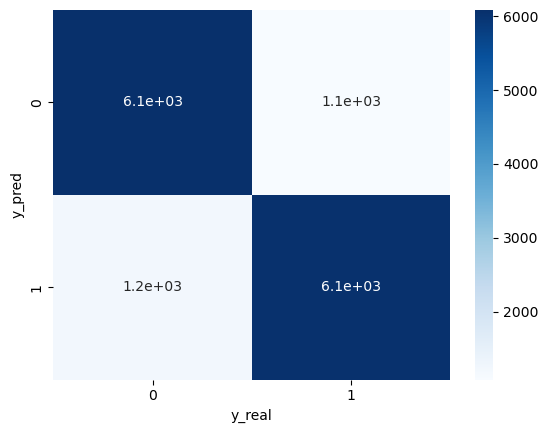

In [27]:
ds_validacion=pd.DataFrame(y_pred_bayes,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [28]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_pred_bayes)
recall=recall_score(y_test_encoded,y_pred_bayes)
f1=f1_score(y_test_encoded,y_pred_bayes)
precision=precision_score(y_test_encoded,y_pred_bayes)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8402628848149429
Recall: 0.8315731724043341
Precision: 0.8486842105263158
f1 score: 0.8400415656390717


In [29]:
y_test_bayes = cv_bayes.predict(test_bow)

In [30]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(y_test_bayes)))\
    .rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('bayes_naive_prediction.csv', index=False)

In [31]:
dump(cv_bayes, 'bayes.joblib')

['bayes.joblib']

### Random Forest

se limpio el output y por falta de tiempo, se deja comentado

In [169]:
# #iteraciones a probar
# n = 50

# #Conjunto de parámetros que quiero usar
# params_grid = {'criterion':['gini','entropy'],
#                'min_samples_leaf':list(range(1,10, 2)),
#                'min_samples_split': list(range(2,10, 2)),
#                'ccp_alpha':np.linspace(0,0.005,5), 
#                'max_depth':list(range(1,10, 2)),
#                'n_estimators': list(range(20,300, 20)),
#                'max_features': ['sqrt'],
#                'n_jobs':[-1]
#               }
# #Random Search Cross Validation
# randomcv = RandomizedSearchCV(estimator=RandomForestClassifier(),
#                               param_distributions = params_grid,
#                               scoring='f1',
#                               cv=StratifiedKFold(n_splits=5),
#                               n_iter=n, 
#                               verbose=10) 

# #Busco los hiperparamtros que optimizan F1 Score
# randomcv.fit(x_train_pca, y_train_encoded);
# randomcv.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START ccp_alpha=0.0025, criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1
[CV 1/5; 1/50] END ccp_alpha=0.0025, criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.707 total time=  14.2s
[CV 2/5; 1/50] START ccp_alpha=0.0025, criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1
[CV 2/5; 1/50] END ccp_alpha=0.0025, criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1;, score=0.728 total time=   9.8s
[CV 3/5; 1/50] START ccp_alpha=0.0025, criterion=entropy, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=100, n_jobs=-1
[CV 3/5; 1/50] END ccp_alpha=0.0025, criterion=entropy, max_depth=3, max_features

[CV 5/5; 5/50] END ccp_alpha=0.00125, criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=9, min_samples_split=4, n_estimators=180, n_jobs=-1;, score=0.776 total time=  35.4s
[CV 1/5; 6/50] START ccp_alpha=0.005, criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=220, n_jobs=-1
[CV 1/5; 6/50] END ccp_alpha=0.005, criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=220, n_jobs=-1;, score=0.750 total time=  42.8s
[CV 2/5; 6/50] START ccp_alpha=0.005, criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=220, n_jobs=-1
[CV 2/5; 6/50] END ccp_alpha=0.005, criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_samples_split=8, n_estimators=220, n_jobs=-1;, score=0.716 total time=  42.8s
[CV 3/5; 6/50] START ccp_alpha=0.005, criterion=entropy, max_depth=7, max_features=sqrt, min_samples_leaf=5, min_sa

[CV 4/5; 10/50] END ccp_alpha=0.0025, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=280, n_jobs=-1;, score=0.736 total time=  22.4s
[CV 5/5; 10/50] START ccp_alpha=0.0025, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=280, n_jobs=-1
[CV 5/5; 10/50] END ccp_alpha=0.0025, criterion=gini, max_depth=3, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, n_estimators=280, n_jobs=-1;, score=0.728 total time=  21.6s
[CV 1/5; 11/50] START ccp_alpha=0.0, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20, n_jobs=-1
[CV 1/5; 11/50] END ccp_alpha=0.0, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_estimators=20, n_jobs=-1;, score=0.562 total time=   1.3s
[CV 2/5; 11/50] START ccp_alpha=0.0, criterion=gini, max_depth=1, max_features=sqrt, min_samples_leaf=3, min_samples_split=6, n_es

KeyboardInterrupt: 

In [170]:
#iteraciones a probar
n = 1

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini'],
               'min_samples_leaf':[1],
               'min_samples_split': [4],
               'ccp_alpha':[0.00125], 
               'max_depth':[9],
               'n_estimators': [160],
               'max_features': ['sqrt'],
               'n_jobs':[-1]
              }
#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=RandomForestClassifier(),
                              param_distributions = params_grid,
                              scoring='f1',
                              cv=StratifiedKFold(n_splits=5),
                              n_iter=n, 
                              verbose=10) 

#Busco los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train_pca, y_train_encoded);
randomcv.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ccp_alpha=0.00125, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, n_jobs=-1
[CV 1/5; 1/1] END ccp_alpha=0.00125, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, n_jobs=-1;, score=0.767 total time=  33.2s
[CV 2/5; 1/1] START ccp_alpha=0.00125, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, n_jobs=-1
[CV 2/5; 1/1] END ccp_alpha=0.00125, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, n_jobs=-1;, score=0.769 total time=  30.9s
[CV 3/5; 1/1] START ccp_alpha=0.00125, criterion=gini, max_depth=9, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=160, n_jobs=-1
[CV 3/5; 1/1] END ccp_alpha=0.00125, criterion=gini, max_depth=9, max_features=sqrt, min_samples_le

{'n_jobs': -1,
 'n_estimators': 160,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 9,
 'criterion': 'gini',
 'ccp_alpha': 0.00125}

In [171]:
y_predict_rf = randomcv.predict(x_test_pca)

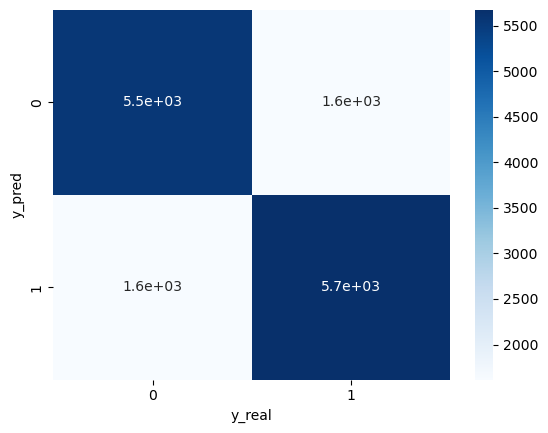

In [172]:
ds_validacion=pd.DataFrame(y_predict_rf,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [173]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_predict_rf)
recall=recall_score(y_test_encoded,y_predict_rf)
f1=f1_score(y_test_encoded,y_predict_rf)
precision=precision_score(y_test_encoded,y_predict_rf)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.7762711864406779
Recall: 0.7779454121519682
Precision: 0.7783724440784959
f1 score: 0.7781588695294278


In [174]:
y_test_rf = randomcv.predict(test_pca)

In [175]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(y_test_rf))).rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('random_forest_prediction.csv', index=False)

In [ ]:
dump(randomcv, 'rf.joblib')

### XGBoost

In [34]:
f1_scorer = make_scorer(f1_score, average='weighted')

params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1],
    'reg_alpha': [0, 0.001, 0.01],
    'reg_lambda': [0, 0.001, 0.01],
    'gamma': [0, 0.001, 0.01],
    'n_jobs':[-1]
}

xgb_model = xgb.XGBClassifier()
rcv_xgboost = RandomizedSearchCV(xgb_model, params, scoring='f1',n_iter=35, cv=5,verbose = 10)
rcv_xgboost.fit(x_train_pca, y_train_encoded)
rcv_xgboost.best_params_

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5; 1/35] START colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, reg_alpha=0.001, reg_lambda=0.001, subsample=0.9
[CV 1/5; 1/35] END colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, reg_alpha=0.001, reg_lambda=0.001, subsample=0.9;, score=0.836 total time= 7.7min
[CV 2/5; 1/35] START colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, reg_alpha=0.001, reg_lambda=0.001, subsample=0.9
[CV 2/5; 1/35] END colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, reg_alpha=0.001, reg_lambda=0.001, subsample=0.9;, score=0.836 total time= 7.7min
[CV 3/5; 1/35] START colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth=4, n_estimators=300, n_jobs=-1, reg_alpha=0.001, reg_lambda=0.001, subsample=0.9
[CV 3/5; 1/35] END colsample_bytree=1, gamma=0, learning_rate=0.1, max_depth

[CV 4/5; 5/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=300, n_jobs=-1, reg_alpha=0.001, reg_lambda=0, subsample=1;, score=0.802 total time= 8.2min
[CV 5/5; 5/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=300, n_jobs=-1, reg_alpha=0.001, reg_lambda=0, subsample=1
[CV 5/5; 5/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=300, n_jobs=-1, reg_alpha=0.001, reg_lambda=0, subsample=1;, score=0.813 total time= 7.6min
[CV 1/5; 6/35] START colsample_bytree=0.9, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0.001, subsample=1
[CV 1/5; 6/35] END colsample_bytree=0.9, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0.001, subsample=1;, score=0.833 total time= 3.7min
[CV 2/5; 6/35] START colsample_bytree=0.9, gamma=0.01, learning_rate=0.1, max_depth=3, n_estimators=200, n

[CV 3/5; 10/35] END colsample_bytree=1, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0.01, subsample=0.8;, score=0.805 total time= 4.9min
[CV 4/5; 10/35] START colsample_bytree=1, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0.01, subsample=0.8
[CV 4/5; 10/35] END colsample_bytree=1, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0.01, subsample=0.8;, score=0.795 total time= 4.9min
[CV 5/5; 10/35] START colsample_bytree=1, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0.01, subsample=0.8
[CV 5/5; 10/35] END colsample_bytree=1, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0.01, subsample=0.8;, score=0.805 total time= 4.9min
[CV 1/5; 11/35] START colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100,

[CV 1/5; 15/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0.001, reg_lambda=0, subsample=1;, score=0.786 total time= 2.6min
[CV 2/5; 15/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0.001, reg_lambda=0, subsample=1
[CV 2/5; 15/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0.001, reg_lambda=0, subsample=1;, score=0.788 total time= 2.6min
[CV 3/5; 15/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0.001, reg_lambda=0, subsample=1
[CV 3/5; 15/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0.001, reg_lambda=0, subsample=1;, score=0.793 total time= 2.6min
[CV 4/5; 15/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estim

[CV 5/5; 19/35] END colsample_bytree=1, gamma=0, learning_rate=0.001, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0.01, reg_lambda=0, subsample=0.9;, score=0.768 total time= 2.7min
[CV 1/5; 20/35] START colsample_bytree=1, gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, n_jobs=-1, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9
[CV 1/5; 20/35] END colsample_bytree=1, gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, n_jobs=-1, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9;, score=0.774 total time= 3.7min
[CV 2/5; 20/35] START colsample_bytree=1, gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, n_jobs=-1, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9
[CV 2/5; 20/35] END colsample_bytree=1, gamma=0.001, learning_rate=0.001, max_depth=5, n_estimators=100, n_jobs=-1, reg_alpha=0.01, reg_lambda=0.01, subsample=0.9;, score=0.780 total time= 3.3min
[CV 3/5; 20/35] START colsample_bytree=1, gamma=0.001, learning_rate=0.001, max_depth=5, 

[CV 4/5; 24/35] END colsample_bytree=1, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, reg_alpha=0.01, reg_lambda=0.001, subsample=1;, score=0.803 total time=10.6min
[CV 5/5; 24/35] START colsample_bytree=1, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, reg_alpha=0.01, reg_lambda=0.001, subsample=1
[CV 5/5; 24/35] END colsample_bytree=1, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=300, n_jobs=-1, reg_alpha=0.01, reg_lambda=0.001, subsample=1;, score=0.816 total time=10.6min
[CV 1/5; 25/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=-1, reg_alpha=0.01, reg_lambda=0, subsample=0.8
[CV 1/5; 25/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.1, max_depth=5, n_estimators=200, n_jobs=-1, reg_alpha=0.01, reg_lambda=0, subsample=0.8;, score=0.835 total time= 5.6min
[CV 2/5; 25/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.1, max_depth=5, n_est

[CV 2/5; 29/35] END colsample_bytree=0.8, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=0.9;, score=0.806 total time= 5.4min
[CV 3/5; 29/35] START colsample_bytree=0.8, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=0.9
[CV 3/5; 29/35] END colsample_bytree=0.8, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=0.9;, score=0.810 total time= 5.4min
[CV 4/5; 29/35] START colsample_bytree=0.8, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=0.9
[CV 4/5; 29/35] END colsample_bytree=0.8, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=200, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=0.9;, score=0.801 total time= 6.2min
[CV 5/5; 29/35] START colsample_bytree=0.8, gamma=0.001, learning_rate=0.01, max_depth=5, n_estimators=200,

[CV 1/5; 34/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=1;, score=0.786 total time= 2.6min
[CV 2/5; 34/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=1
[CV 2/5; 34/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=1;, score=0.788 total time= 2.6min
[CV 3/5; 34/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=1
[CV 3/5; 34/35] END colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1, reg_alpha=0, reg_lambda=0, subsample=1;, score=0.793 total time= 2.9min
[CV 4/5; 34/35] START colsample_bytree=0.9, gamma=0.001, learning_rate=0.01, max_depth=4, n_estimators=100, n_jobs=-1

{'subsample': 0.9,
 'reg_lambda': 0.001,
 'reg_alpha': 0.001,
 'n_jobs': -1,
 'n_estimators': 300,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 1}

In [35]:
y_predict_xbg = rcv_xgboost.predict(x_test_pca)

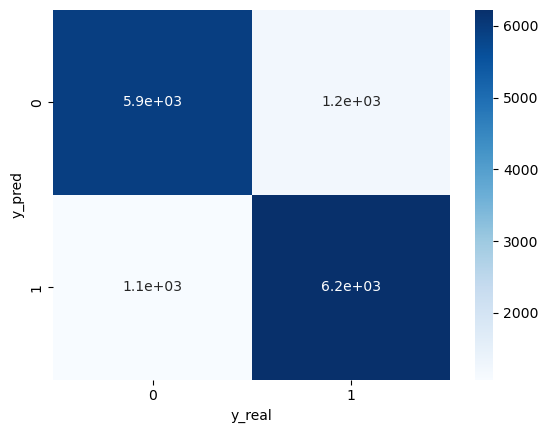

In [36]:
ds_validacion=pd.DataFrame(y_predict_xbg,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [37]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_predict_xbg)
recall=recall_score(y_test_encoded,y_predict_xbg)
f1=f1_score(y_test_encoded,y_predict_xbg)
precision=precision_score(y_test_encoded,y_predict_xbg)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8410930473884469
Recall: 0.8532437251405843
Precision: 0.8352577873254565
f1 score: 0.8441549630232718


In [38]:
y_test_xbg = rcv_xgboost.predict(test_pca)

In [39]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(y_test_xbg)))\
    .rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('xgboost_prediction.csv', index=False)

In [40]:
dump(rcv_xgboost, 'xgb.joblib')

['xgb.joblib']

## Red Neuronal

### Normalizo

In [42]:
stand_scaler = StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train_pca)
x_test_norm=stand_scaler.transform(x_test_pca)
test_norm=stand_scaler.transform(test_pca)

In [43]:
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=x_train_pca.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [44]:
neural_network = KerasClassifier(build_fn=create_model, verbose=10)

# Definir los hiperparámetros a probar en la búsqueda de grid
param_grid = {
    'batch_size': [16, 32,48],
    'epochs': [10, 20,30,40]
}

/tmp/ipykernel_42847/1975443401.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  neural_network = KerasClassifier(build_fn=create_model, verbose=10)


In [45]:
kfold = StratifiedKFold(n_splits=5)
scorer = make_scorer(f1_score)
grid_search = GridSearchCV(estimator=neural_network, param_grid=param_grid, cv=kfold, scoring=scorer,verbose =10)
grid_search.fit(x_train_norm, y_train_encoded)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START batch_size=16, epochs=10...................................
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
211/211 [==============================] - 0s 541us/step
[CV 1/5; 1/12] END ....batch_size=16, epochs=10;, score=0.837 total time=  23.5s
[CV 2/5; 1/12] START batch_size=16, epochs=10...................................
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
211/211 [==============================] - 0s 513us/step
[CV 2/5; 1/12] END ....batch_size=16, epochs=10;, score=0.846 total time=  23.3s
[CV 3/5; 1/12] START batch_size=16, epochs=10...................................
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
211/211 [==============================] - 0s 531us/step
[CV 3/5; 1/12] END ....batch_s

Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40
211/211 [==============================] - 0s 524us/step
[CV 3/5; 4/12] END ....batch_size=16, epochs=40;, score=0.851 total time= 1.5min
[CV 4/5; 4/12] START batch_size=16, epochs=40...................................
Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 2

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
211/211 [==============================] - 0s 526us/step
[CV 5/5; 7/12] END ....batch_size=32, epochs=30;, score=0.839 total time=  37.9s
[CV 1/5; 8/12] START batch_size=32, epochs=40...................................
Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 3

Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
211/211 [==============================] - 0s 553us/step
[CV 1/5; 11/12] END ...batch_size=48, epochs=30;, score=0.836 total time=  27.9s
[CV 2/5; 11/12] START batch_size=48, epochs=30..................................
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
211/211 [==============================] - 0s 536us/step
[CV 2/5; 11/12] END ...batch_size=48, epochs=30;, score=0.840 total time=  27.8s
[CV 3/5; 11/12] START batch_size=48, epochs=30..................................
Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoc

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7f68813db100>,
             param_grid={'batch_size': [16, 32, 48],
                         'epochs': [10, 20, 30, 40]},
             scoring=make_scorer(f1_score), verbose=10)

In [46]:
print("Mejor precisión encontrada:", grid_search.best_score_)
print("Mejores parámetros:", grid_search.best_params_)

Mejor precisión encontrada: 0.8419247380045629
Mejores parámetros: {'batch_size': 16, 'epochs': 40}


In [47]:
y_predict_red = grid_search.predict(x_test_norm)

452/452 [==============================] - 0s 584us/step


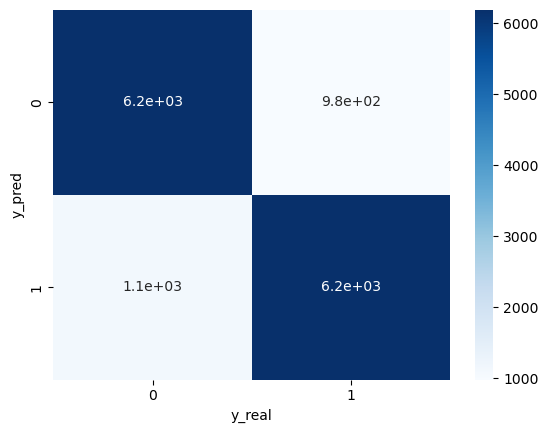

In [48]:
ds_validacion=pd.DataFrame(y_predict_red,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [49]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_predict_red)
recall=recall_score(y_test_encoded,y_predict_red)
f1=f1_score(y_test_encoded,y_predict_red)
precision=precision_score(y_test_encoded,y_predict_red)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8545140089934279
Recall: 0.8461116444932109
Precision: 0.8627972027972028
f1 score: 0.85437296586109


In [50]:
y_test_red = grid_search.predict(test_norm)

269/269 [==============================] - 0s 543us/step


In [51]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(y_test_red)))\
    .rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('red_prediction.csv', index=False)

/home/elpolako/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [52]:
dump(grid_search, 'red.joblib')

['red.joblib']

## ensambles

### Staking

#### XGBoost

In [ ]:
xgb = joblib.load('xgb.joblib')
rf = joblib.load('rf.joblib')
bayes = joblib.load('bayes.joblib')
red = joblib.load('red.joblib')

In [131]:
# bayes -> x_train_bow
# xgb -> PCA(n_components=4000) 
# red -> PCA(n_components=4000)  + StandardScaler()

In [132]:
classifier_red = Pipeline([
    ('reductor', PCA(n_components=4000)),
    ('normalizer', StandardScaler()),
    ('classifier', red.best_estimator_)
])

classifier_xgb = Pipeline([
    ('reductor', PCA(n_components=4000)),
    ('classifier', xgb.best_estimator_)
])

# Crear un ensamblaje tipo stacking con los modelos
estimators = [
    ('red', classifier_red),
    ('xgb', classifier_xgb),
    ('bayes', bayes.best_estimator_)
]

In [133]:
stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), cv=3,verbose = 10)
stacking_classifier.fit(x_train_bow, y_train_encoded)
stacking_classifier.score(x_test_bow, y_test_encoded)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 540us/step


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 535us/step


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.1min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 585us/step


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


452/452 [==============================] - 0s 542us/step


0.8689726738152889

In [134]:
y_test_stacking_xgb = stacking_classifier.predict(x_test_bow)

452/452 [==============================] - 0s 578us/step


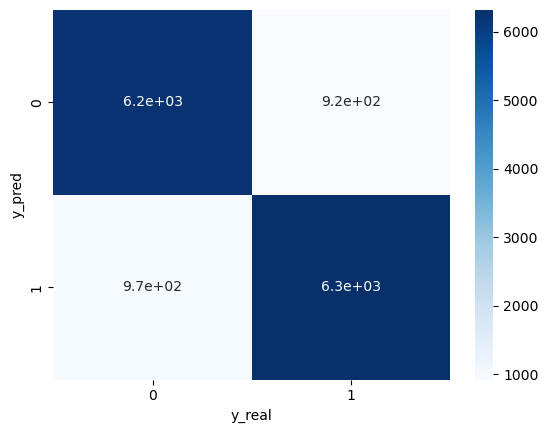

In [135]:
ds_validacion=pd.DataFrame(y_test_stacking_xgb,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [136]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_test_stacking_xgb)
recall=recall_score(y_test_encoded,y_test_stacking_xgb)
f1=f1_score(y_test_encoded,y_test_stacking_xgb)
precision=precision_score(y_test_encoded,y_test_stacking_xgb)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8689726738152889
Recall: 0.866684954052942
Precision: 0.8726695207844221
f1 score: 0.8696669419212771


In [137]:
test_stacking_xgb = stacking_classifier.predict(test_bow)

269/269 [==============================] - 0s 526us/step


In [138]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(test_stacking_xgb)))\
    .rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('staking_xgb.csv', index=False)

In [139]:
dump(grid_search, 'staking_xgb.joblib')

['staking_xgb.joblib']

#### Logistic Regression

In [140]:
from sklearn.linear_model import LogisticRegression

stacking_classifier_log = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=3,verbose = 10)
stacking_classifier_log.fit(x_train_bow, y_train_encoded)
stacking_classifier_log.score(x_test_bow, y_test_encoded)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 590us/step


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 523us/step


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.1min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 515us/step


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.9min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


452/452 [==============================] - 0s 516us/step


0.8723625043237634

In [141]:
y_test_stacking_log = stacking_classifier_log.predict(x_test_bow)

452/452 [==============================] - 0s 543us/step


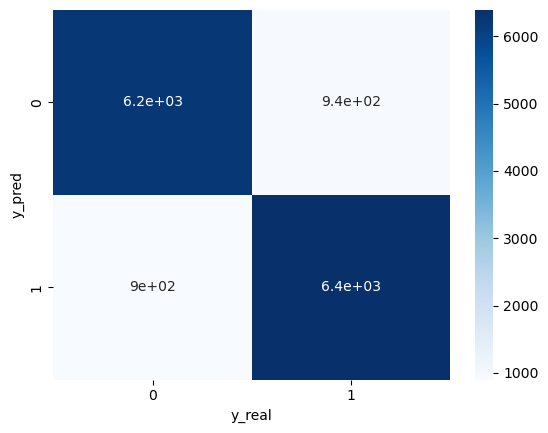

In [142]:
ds_validacion=pd.DataFrame(y_test_stacking_log,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [143]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_test_stacking_log)
recall=recall_score(y_test_encoded,y_test_stacking_log)
f1=f1_score(y_test_encoded,y_test_stacking_log)
precision=precision_score(y_test_encoded,y_test_stacking_log)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8723625043237634
Recall: 0.8762858318474832
Precision: 0.8713857064920895
f1 score: 0.8738288996785886


In [144]:
test_stacking_log = stacking_classifier_log.predict(test_bow)

269/269 [==============================] - 0s 573us/step


In [145]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(test_stacking_log)))\
    .rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('stacking_log.csv', index=False)

In [165]:
dump(stacking_classifier_log, 'stacking_classifier_log.joblib')

['stacking_classifier_log.joblib']

#### RandomForest

In [146]:
stacking_classifier_rf = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(), cv=3,verbose = 10)
stacking_classifier_rf.fit(x_train_bow, y_train_encoded)
stacking_classifier_rf.score(x_test_bow, y_test_encoded)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 556us/step


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 553us/step


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.1min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 533us/step


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 10.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.7min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.5min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished


452/452 [==============================] - 0s 550us/step


0.8643375994465583

In [147]:
y_test_stacking_rf = stacking_classifier_rf.predict(x_test_bow)

452/452 [==============================] - 0s 531us/step


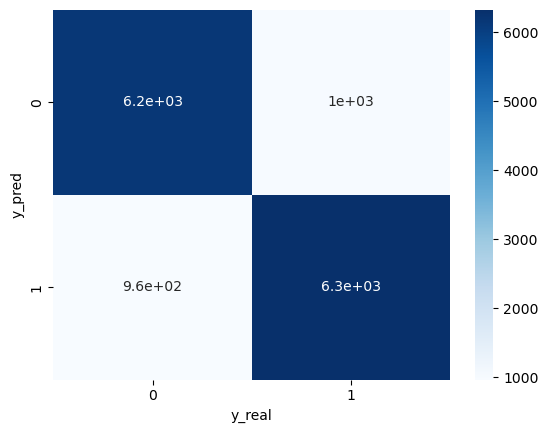

In [148]:
ds_validacion=pd.DataFrame(y_test_stacking_rf,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [149]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_test_stacking_rf)
recall=recall_score(y_test_encoded,y_test_stacking_rf)
f1=f1_score(y_test_encoded,y_test_stacking_rf)
precision=precision_score(y_test_encoded,y_test_stacking_rf)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8643375994465583
Recall: 0.8676450418323961
Precision: 0.8639715924610762
f1 score: 0.8658044207212756


In [150]:
test_stacking_rf = stacking_classifier_rf.predict(test_bow)

269/269 [==============================] - 0s 624us/step


In [151]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(test_stacking_rf)))\
    .rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('stacking_rf.csv', index=False)

In [166]:
dump(stacking_classifier_rf, 'stacking_classifier_rf.joblib')

['stacking_classifier_rf.joblib']

#### SVC

In [152]:
from sklearn.svm import SVC
stacking_classifier_svc = StackingClassifier(estimators=estimators, final_estimator=SVC(), cv=3,verbose = 10)
stacking_classifier_svc.fit(x_train_bow, y_train_encoded)
stacking_classifier_svc.score(x_test_bow, y_test_encoded)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 515us/step


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 534us/step


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.4min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 594us/step


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s finished


452/452 [==============================] - 0s 553us/step


0.8712556208924248

In [153]:
y_test_stacking_svc = stacking_classifier_svc.predict(x_test_bow)

452/452 [==============================] - 0s 522us/step


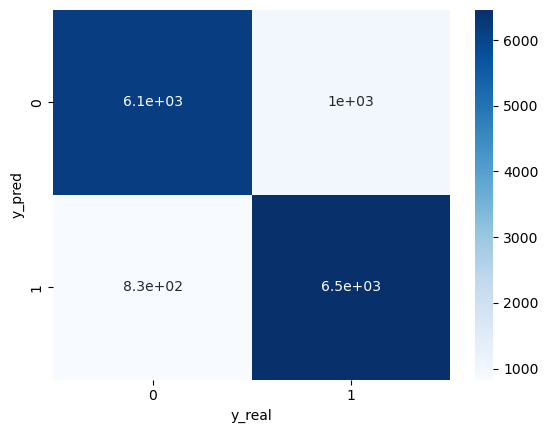

In [154]:
ds_validacion=pd.DataFrame(y_test_stacking_svc,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [155]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_test_stacking_svc)
recall=recall_score(y_test_encoded,y_test_stacking_svc)
f1=f1_score(y_test_encoded,y_test_stacking_svc)
precision=precision_score(y_test_encoded,y_test_stacking_svc)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8712556208924248
Recall: 0.8856123988478947
Precision: 0.8627739176910743
f1 score: 0.8740439932318106


In [156]:
test_stacking_svc = stacking_classifier_svc.predict(test_bow)

269/269 [==============================] - 0s 589us/step


In [157]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(test_stacking_svc)))\
    .rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('stacking_svc.csv', index=False)

In [167]:
dump(stacking_classifier_svc, 'stacking_classifier_svc.joblib')

['stacking_classifier_svc.joblib']

#### MLPClassifier

In [158]:
from sklearn.neural_network import MLPClassifier
stacking_classifier_red = StackingClassifier(estimators=estimators, final_estimator=MLPClassifier(), cv=3,verbose = 10)
stacking_classifier_red.fit(x_train_bow, y_train_encoded)
stacking_classifier_red.score(x_test_bow, y_test_encoded)

Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 565us/step


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.8min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 519us/step


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.6min remaining:    0.0s


Epoch 1/30
Epoch 2/30
Epoch 3/30
Epoch 4/30
Epoch 5/30
Epoch 6/30
Epoch 7/30
Epoch 8/30
Epoch 9/30
Epoch 10/30
Epoch 11/30
Epoch 12/30
Epoch 13/30
Epoch 14/30
Epoch 15/30
Epoch 16/30
Epoch 17/30
Epoch 18/30
Epoch 19/30
Epoch 20/30
Epoch 21/30
Epoch 22/30
Epoch 23/30
Epoch 24/30
Epoch 25/30
Epoch 26/30
Epoch 27/30
Epoch 28/30
Epoch 29/30
Epoch 30/30
352/352 [==============================] - 0s 550us/step


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.4min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.4s finished


452/452 [==============================] - 0s 502us/step


0.8725008647526807

In [159]:
y_test_stacking_red = stacking_classifier_red.predict(x_test_bow)

452/452 [==============================] - 0s 530us/step


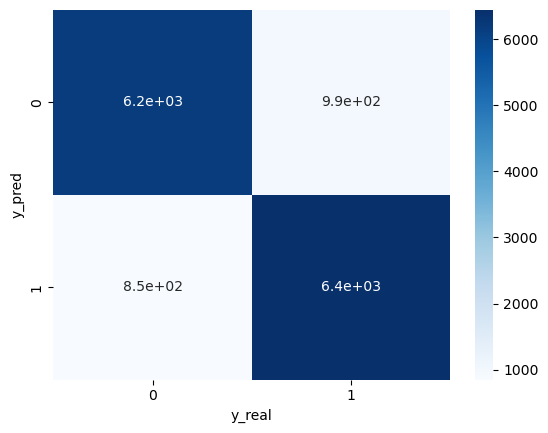

In [160]:
ds_validacion=pd.DataFrame(y_test_stacking_red,y_test_encoded).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [161]:
#Calculo las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test_encoded,y_test_stacking_red)
recall=recall_score(y_test_encoded,y_test_stacking_red)
f1=f1_score(y_test_encoded,y_test_stacking_red)
precision=precision_score(y_test_encoded,y_test_stacking_red)

print("Accuracy: "+str(accuracy))
print("Recall: "+str(recall))
print("Precision: "+str(precision))
print("f1 score: "+str(f1))

Accuracy: 0.8725008647526807
Recall: 0.8835550678919215
Precision: 0.866325981710597
f1 score: 0.8748557072044543


In [162]:
test_stacking_red = stacking_classifier_red.predict(test_bow)

269/269 [==============================] - 0s 548us/step


In [163]:
df_prediction = pd.DataFrame(zip(df_test['ID'],label_encoder.inverse_transform(test_stacking_red)))\
    .rename(columns={0: "ID", 1: "sentimiento"})
df_prediction.to_csv('stacking_red.csv', index=False)

In [168]:
dump(stacking_classifier_red, 'stacking_classifier_red.joblib')

['stacking_classifier_red.joblib']